In [1]:
from hyperopt import hp
import datetime
import numpy as np
import os
import pandas as pd
import plotly.express as px

# Location
#/Users/Jeroen/Code/autoxgb/temp_notebooks
DATA_DIR = '/Users/Jeroen/Code/autoxgb/data/metadata/raw/'

# Create directories for visualizations if they don't exist yet.
for dir_path in [DATA_DIR]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

import plotly.offline as py
import plotly.graph_objects as go
py.init_notebook_mode(connected=True)

# Search Space bounds choice

This notebook will show how the bounds of the search domain are derived. Some points to take into consideration:
- a too large space:
    - no fair comparison warmstart/naive
    - not granular enough??
    - computational complexity blows up for high max_depth and num_trees
 - a too small space:
    - the optimum is not representative of the global optimum? -> might mix up the usability of metafeatures?
        - dataset length might indicate a num_trees/learning_rate ratio?
        - overfitting, don't know specifically?

### Bounds constraints visualization

1. histogram of best 10% hyperparameters for one search_frame

In [2]:
df = pd.read_csv(DATA_DIR + 'COAST_box_17520.csv', index_col=0, header=[0,1])

In [3]:
nt = df.iloc[:30]['hyperparameters']

In [4]:
fig = px.histogram(nt, x='max_depth', nbins=20)

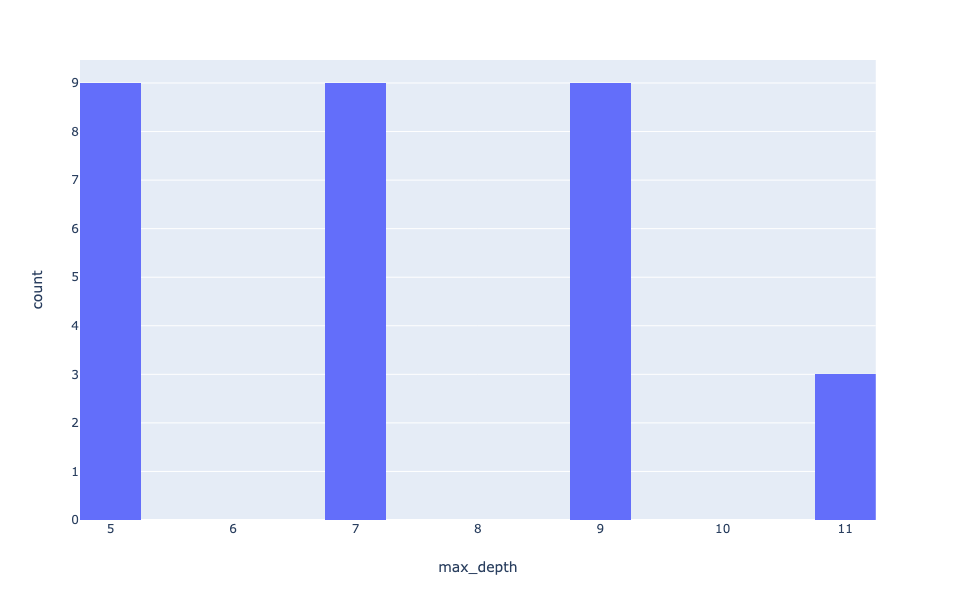

In [5]:
fig.show()

2. histogram of best 10% hyperparameters for multiple search_frames + make beautiful

In [6]:
search_space = {
    'num_trees': np.linspace(100, 800, 6),
    'learning_rate': np.logspace(-2.5, -0.5, 10),
    'max_depth': np.linspace(5, 20, 8),
    'min_child_weight': np.linspace(5, 40, 3),
    'subsample': np.linspace(0.5, 1.0, 3)
}

In [7]:
search_space = {
    'num_trees': {
        'range': [100, 800],
        'scale': 'linear',
    },
    'learning_rate': {
        'range': [-2.5, -0.5],
        'scale': 'log',
    },
    'max_depth': {
        'range': [5, 20],
        'scale': 'linear',
    },
    'min_child_weight': {
        'range': [5, 40],
        'scale': 'linear',
    },
    'subsample': {
        'range': [0.5, 1.0],
        'scale': 'linear',
    },
}

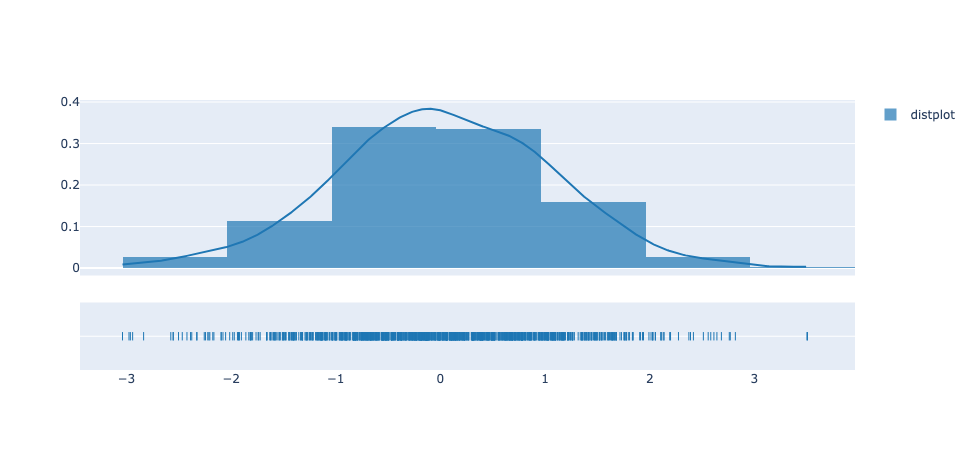

In [8]:
import plotly.figure_factory as ff
import numpy as np

x = np.random.randn(1000)
hist_data = [x]
group_labels = ['distplot'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

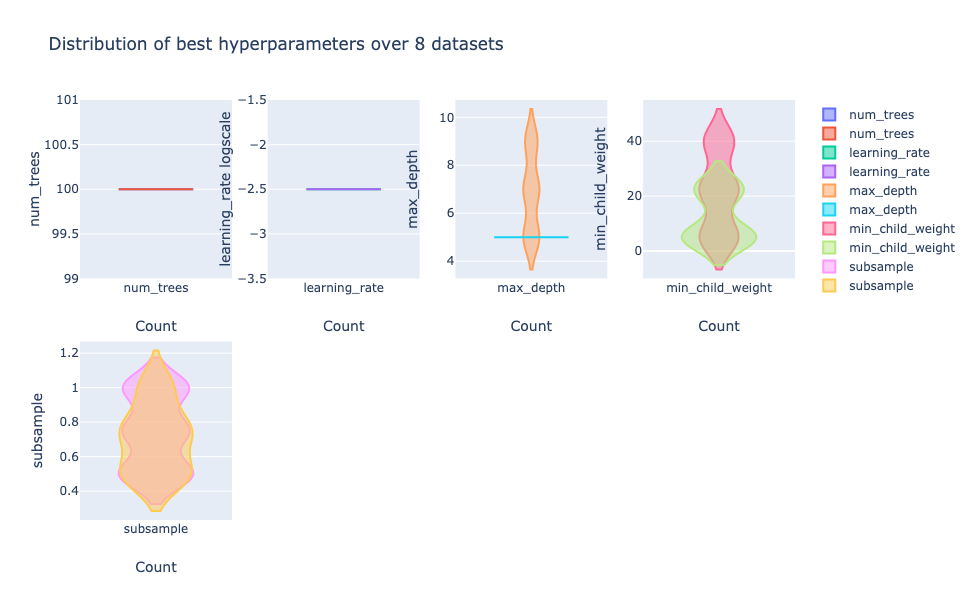

In [10]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# set params
n_best_small = 5
n_best_big = 25
n_bins = 10

# import data
result_sources = ['COAST_box_17520.csv','EAST_diff_17520.csv','FARWEST_box_8760.csv','NORTH_diff_8760.csv']
results = [pd.read_csv(DATA_DIR + result_source, index_col=0, header=[0,1]) for result_source in result_sources]

# get small subset of best hyperparameters per search frame and concat, concat this for multipe search frames
best_one_list = [result.iloc[:n_best_small]['hyperparameters'] for result in results]
best_one_hyperparameters = pd.concat(best_one_list)

# get bigger subset of best hyperparameter settings of a search frame, concat this for multipe search frames
best_multiple_list = [result.iloc[:n_best_big]['hyperparameters'] for result in results]
best_multiple_hyperparameters = pd.concat(best_multiple_list)

# define subplots
fig = make_subplots(
    rows=2,
    cols=4
)
subplot_place = [[1,1],[1,2],[1,3],[1,4],[2,1],[2,2],[2,3],[2,4]]

for i, hyperp_name in enumerate(search_space.keys()):
    # add best multiple traces
    if search_space[hyperp_name]['scale'] == 'log':
        trace = go.Violin(
            y=np.log10(best_multiple_hyperparameters[hyperp_name]),
            name=hyperp_name,
            scalegroup=hyperp_name
        )
        fig.add_trace(
            trace,
            row=subplot_place[i][0],
            col=subplot_place[i][1],
        )
        fig.update_xaxes(title_text='Count')
        fig.update_yaxes(title_text=hyperp_name + ' logscale', row=subplot_place[i][0], col=subplot_place[i][1])#, range=search_space[hyperp_name]['range'])
    else:
        trace = go.Violin(
            y=best_multiple_hyperparameters[hyperp_name],
            name=hyperp_name,
            scalegroup=hyperp_name
        )
        fig.add_trace(
            trace,
            row=subplot_place[i][0],
            col=subplot_place[i][1],
        )
        fig.update_xaxes(title_text='Count')
        fig.update_yaxes(title_text=hyperp_name, row=subplot_place[i][0], col=subplot_place[i][1])#, range=search_space[hyperp_name]['range'])
    # add best single traces
    if search_space[hyperp_name]['scale'] == 'log':
        trace = go.Violin(
            y=np.log10(best_one_hyperparameters[hyperp_name]),
            name=hyperp_name,
            scalegroup=hyperp_name
        )
        fig.add_trace(
            trace,
            row=subplot_place[i][0],
            col=subplot_place[i][1],
        )
        fig.update_xaxes(title_text='Count')
        fig.update_yaxes(title_text=hyperp_name + ' logscale', row=subplot_place[i][0], col=subplot_place[i][1])#, range=search_space[hyperp_name]['range'])
    else:
        trace = go.Violin(
            y=best_one_hyperparameters[hyperp_name],
            name=hyperp_name,
            scalegroup=hyperp_name
        )
        fig.add_trace(
            trace,
            row=subplot_place[i][0],
            col=subplot_place[i][1],
        )
        fig.update_xaxes(title_text='Count')
        fig.update_yaxes(title_text=hyperp_name, row=subplot_place[i][0], col=subplot_place[i][1])#, range=search_space[hyperp_name]['range'])
    fig.update_layout(height=600, width=1200, title_text="Distribution of best hyperparameters over 8 datasets")
fig.show()

In [11]:
np.logspace(-1,-2.5,5)

array([0.1       , 0.04216965, 0.01778279, 0.00749894, 0.00316228])

In [12]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# set params
n_best_small = 5
n_best_big = 25
n_bins = 10

# import data
result_sources = ['COAST_big_box_result.csv','EAST_big_box_result.csv','FARWEST_small_box_result.csv','NORTH_small_diff_result.csv','NORTHC_small_box_result.csv','SOUTHC_big_diff_result.csv','SOUTHERN_big_diff_result.csv','WEST_small_diff_result.csv']
results = [pd.read_csv(DATA_DIR + result_source, index_col=0, header=[0,1]) for result_source in result_sources]

# get small subset of best hyperparameters per search frame and concat, concat this for multipe search frames
best_one_list = [result.iloc[:n_best_small]['hyperparameters'] for result in results]
best_one_hyperparameters = pd.concat(best_one_list)

# get bigger subset of best hyperparameter settings of a search frame, concat this for multipe search frames
best_multiple_list = [result.iloc[:n_best_big]['hyperparameters'] for result in results]
best_multiple_hyperparameters = pd.concat(best_multiple_list)

# define subplots
fig = make_subplots(
    rows=2,
    cols=4
)
subplot_place = [[1,1],[1,2],[1,3],[1,4],[2,1],[2,2],[2,3],[2,4]]

for i, hyperp_name in enumerate(search_space.keys()):
    # add best multiple traces
    if search_space[hyperp_name]['scale'] == 'log':
        trace = go.Histogram(
            x=np.log(best_multiple_hyperparameters[hyperp_name]),
            nbinsx=n_bins,
            name=hyperp_name
        )
        fig.append_trace(
            trace,
            row=subplot_place[i][0],
            col=subplot_place[i][1],
        )
        fig.update_yaxes(title_text='Count')
        fig.update_xaxes(title_text=hyperp_name + ' logscale', row=subplot_place[i][0], col=subplot_place[i][1], range=search_space[hyperp_name]['range'])
    else:
        trace = go.Histogram(
            x=best_multiple_hyperparameters[hyperp_name],
            nbinsx=n_bins,
            name=hyperp_name
        )
        fig.append_trace(
            trace,
            row=subplot_place[i][0],
            col=subplot_place[i][1],
        )
        fig.update_yaxes(title_text='Count')
        fig.update_xaxes(title_text=hyperp_name, row=subplot_place[i][0], col=subplot_place[i][1], range=search_space[hyperp_name]['range'])
    # add best single traces
    if search_space[hyperp_name]['scale'] == 'log':
        trace = go.Histogram(
            x=np.log(best_one_hyperparameters[hyperp_name]),
            nbinsx=n_bins,
            name=hyperp_name
        )
        fig.append_trace(
            trace,
            row=subplot_place[i][0],
            col=subplot_place[i][1],
        )
        fig.update_yaxes(title_text='Count')
        fig.update_xaxes(title_text=hyperp_name + ' logscale', row=subplot_place[i][0], col=subplot_place[i][1], range=search_space[hyperp_name]['range'])
    else:
        trace = go.Histogram(
            x=best_one_hyperparameters[hyperp_name],
            nbinsx=n_bins,
            name=hyperp_name
        )
        fig.append_trace(
            trace,
            row=subplot_place[i][0],
            col=subplot_place[i][1],
        )
        fig.update_yaxes(title_text='Count')
        fig.update_xaxes(title_text=hyperp_name, row=subplot_place[i][0], col=subplot_place[i][1], range=search_space[hyperp_name]['range'])
    fig.update_layout(height=600, width=1200, title_text="Distribution of best hyperparameters over 8 datasets")
fig.show()

FileNotFoundError: [Errno 2] File b'/Users/Jeroen/Code/autoxgb/data/metadata/raw/COAST_big_box_result.csv' does not exist: b'/Users/Jeroen/Code/autoxgb/data/metadata/raw/COAST_big_box_result.csv'